# MINI-PROJECT RECSYS

Today we will build a recommender system (RS) using [*ml-100k* dataset](https://grouplens.org/datasets/movielens/100k/). This data consist on 100,000 ratings from 1000 users on 1700 movies and it is tipically used for either comparing results in SOTA papers or for building toy RS.

1. You first need to create a folder called *data* and then put inside the downloaded dataset. Thus, your data needs to be stored in:
> *./data/ml-100k/all_files_here*.

2. Then, in the next cell you can observe how all the model and pipeline configuration is set up. You can modify any parameter if you want to (like the seed, lr, batch_size or embedding dimension...).

3. Check also that, in order to allow reproducing the results you achieve, the seed you choose is forwaded to all tensorflow, numpy and os libraries.

In [46]:
import os
import csv
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
import tensorflow as tf

2023-05-11 18:32:43.263780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import warnings
warnings.simplefilter('ignore')

DATA_DIR = 'data/ml-100k'
OUTPUT_DIR = './'

class Config:
    category_col = ['user_id','movie_id','Action','Adventure','Animation',"Childrens",'Comedy','Crime',
          'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
          'Romance','Sci-Fi','Thriller','War','Western', 'gender','occupation','year']
    num_col = ['age']
    target_col = ['label']
    
    epochs=5
    batch_size=128
    seed=17
    embedding_dim=8
    lr=1e-4
    

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

In [4]:
config=Config()
seed_everything(config.seed)

## Load data

In this section we will load the three different files available on ml-100k dataset: 

- the data interactions
- the user data
- the item's data

In [5]:
def load_data_df():
    df = pd.read_csv(os.path.join(DATA_DIR, 'u.data'), sep='\t', header=None)
    df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
    return df

def load_item_df():
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
          'unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime',
          'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
          'Romance','Sci-Fi','Thriller','War','Western',]
    item_df = pd.read_csv(os.path.join(DATA_DIR, 'u.item'), sep='|', encoding="iso-8859-1", names=m_cols)
    item_df = item_df.rename(columns={"Children's":'Childrens'})
    return item_df

def load_user_df():
    u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
    user_df = pd.read_csv(os.path.join(DATA_DIR, 'u.user'), sep='|', encoding="iso-8859-1", names=u_cols)
    return user_df

In [6]:
data_df = load_data_df()
item_df = load_item_df()
user_df = load_user_df()

In [7]:
################################
# Excercice 1: 
#
# You can now visualize each of them and get familiar with the data by using dataframe.head() function.
#
###############################

data_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
item_df.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
user_df

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


> #### Please, check the [pandas.merge documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) for more clarifying information about the next exercice.


In [10]:
################################
# Excercice 2: 
#
# Build the following function in order to merge the data into one single dataframe, which needs to be merged by 
# 'inner' mode. 
#
###############################

def merge_df(data_df, item_df, user_df):
    tmp = pd.merge(data_df, item_df)
    tmp = pd.merge(tmp, user_df)
    
    return tmp

In [11]:
df = merge_df(data_df, item_df, user_df)
df.head()

,user_id,movie_id,rating,timestamp,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,49,M,writer,55105
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,49,M,writer,55105
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,49,M,writer,55105
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,49,M,writer,55105
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,49,M,writer,55105


In [12]:
################################
# Excercice 3: 
#
# Check with one command line that our merged dataframe contains 100,000 rows and 31 features per each row. 
#
###############################

# ...
print(df.shape)


(100000, 31)


## Preprocess

In this section we will pre-process the data in order to apply some common filters (such as a a film having a mínimum of 10 views) and also some data transformations to allow the model process numerical and categorical features.

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


def build_preprocessor(config): 
    category_col = config.category_col
    num_col = config.num_col
    
    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std', (StandardScaler())),])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value='NAN')),
        ('oe', (OrdinalEncoder())),
        ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_col),
            ('cat', categorical_transformer, category_col),
        ],
        remainder="drop")
    return preprocessor

In [14]:
################################
# Excercice 4: 
#
# Explain, by understanding the code of the previous cell and by researching in the documentation what is the
# function 'build_preprocessor' doing to our data. Answer in the next cell.
#
###############################

> **Answer here:** 

So in this preprocessor, we are automating pipelines for the transformation of our variables. In specific, what we are doing are:

- **Numerical variables**: First for the NaN, apply the mean of that variable. Then, scale those values with standarization.
- **Categorical variables**: First for the NaN, fill them with the value 'NaN'. Then, apply one-hot encoding.

And with the column transformer, we ensure that those transformations are applied to their corresponding data types.

In [15]:
################################
# Excercice 5: 
#
# Now, by following the next steps we propose, please try to come up with the code that corresponds to the  
# filters that need to be done. We have splitted the steps into a), b), c) and d)
#
###############################

In [16]:
category_col = config.category_col
num_col = config.num_col
target_col = config.target_col[0]

In [17]:
#######
# a) Apply the filter in order to just use movies with more than 10 views
#######

print(df.shape)

movie_id_value_counts = df.movie_id.value_counts()
df = df[df.movie_id.isin(
    movie_id_value_counts.index[(movie_id_value_counts > 10).values]
)]

print(df.shape)

(100000, 31)
(97623, 31)


In [18]:
#######
# b) Extract the year from the 'release_date' column.
#######

df["year"] = pd.to_datetime(df.release_date).dt.year.astype('str')

In [19]:
#######
# c) Create a label column for binary classification from the 'rating' column. If rating >=4, we want the target_col
#    to be 1, and if not 0. 
#######

df['label'] = np.where(df.rating >= 4, 1, 0)
df[target_col]

0        0
1        0
2        1
3        1
4        1
        ..
99995    1
99996    1
99997    0
99998    0
99999    1
Name: label, Length: 97623, dtype: int64

In [20]:
df[category_col].head()

,user_id,movie_id,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,gender,occupation,year
0,196,242,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,M,writer,1997
1,196,257,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,M,writer,1997
2,196,111,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,M,writer,1996
3,196,25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,M,writer,1996
4,196,382,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,M,writer,1994


In [21]:
# Build pipeline
pp = build_preprocessor(config)
pp.fit(df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std', StandardScaler())]),
                                 ['age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='NAN',
                                                                strategy='constant')),
                                                 ('oe', OrdinalEncoder())]),
                                 ['user_id', 'movie_id', 'Action', 'Adventure',
                                  'Animation', 'Childrens', 'Comedy', 'Crime',
                                  'Documentary', 'Drama', 'Fantasy',
                                  'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                  'Romance', 'Sci-Fi', 'Thriller', 'War',
                                  'Western', 'gender', 'occupation', 'year'])])

In [22]:
# Check that it transforms the data (do not do it yet)
pp.transform(df).shape

(97623, 24)

In [23]:
df[num_col+category_col]

,age,user_id,movie_id,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,gender,occupation,year
0,49,196,242,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,M,writer,1997
1,49,196,257,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,M,writer,1997
2,49,196,111,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,M,writer,1996
3,49,196,25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,M,writer,1996
4,49,196,382,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,M,writer,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,48,873,313,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,F,administrator,1997
99996,48,873,326,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,F,administrator,1997
99997,48,873,348,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,F,administrator,1998
99998,48,873,358,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,F,administrator,1997


In [95]:
#######
# d) Split the data into 80% (train) and 20% (test) with the imported function 'train_test_split'. Look at the 
#    documentation and use df['movie_id'] as 'stratify' parameter and config.seed as 'random_state'.
#######

tra_df, val_df = train_test_split(
    df, 
    stratify=df['movie_id'], 
    random_state=42, 
    test_size=.2
)

tra_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

print(tra_df.shape)
print(val_df.shape)

(78098, 33)
(19525, 33)


In [25]:
assert tra_df.movie_id.nunique() == val_df.movie_id.nunique()
assert len(set(val_df.user_id) - set(tra_df.user_id)) == 0

## Training

In this section we will build the model and train it with the data we have been preparing.

In [26]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, add, Activation, dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import itertools


def build_model(
    category_num, 
    category_cols, 
    num_cols, 
    K=8, 
    l2=0.0, 
    l2_fm=0.0
):

    # Numerical features
    num_inputs = [Input(shape=(1,), name=col,) for col in num_cols]
    # Categorical features
    cat_inputs = [Input(shape=(1,), name=col,) for col in category_cols]

    inputs = num_inputs + cat_inputs

    flatten_layers=[]
    # Numerical featrue embedding
    for enc_inp, col in zip(num_inputs, num_cols):
        # num feature dense
        x = Dense(K, name = f'embed_{col}', kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_layers.append(x)

    # Category feature embedding
    for enc_inp, col in zip(cat_inputs, category_cols):
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=K,
                            input_length=1,
                            name=f'embed_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        flatten_layers.append(flatten_c)
                
    # Feature interaction term
    fm_layers = []
    for emb1,emb2 in itertools.combinations(flatten_layers, 2):
        dot_layer = dot([emb1,emb2], axes=1)
        fm_layers.append(dot_layer)        

    # Linear term
    for enc_inp,col in zip(cat_inputs, category_cols):
        # embedding
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=1,
                            input_length=1,
                            name=f'linear_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        fm_layers.append(flatten_c)
                
    for enc_inp, col in zip(num_inputs, num_cols):
        x = Dense(1, name = f'linear_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        fm_layers.append(x)

    # Add all terms
    flatten = add(fm_layers)
    outputs = Activation('sigmoid',name='outputs')(flatten)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model    

In [73]:
################################
# Excercice 6: 
#
# Make sure you understand the model from above and then call an instance of it and compile it with 
# optimizer 'adam', loss 'binary_crossentropy' and metrics 'accuracy'.
#
###############################

category_num = {col: df[col].nunique() for col in config.category_col}

model = build_model(category_num, category_col, num_col)

In [74]:
adam = tf.keras.optimizers.Adam(0.0003)

model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Now we will build an 'early stopping' callback and also transform the training and validation dataframes with the **pp.transform** function we tested at the beggining of the notebook.

In [75]:
cb = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0,)]

feature_num = len(config.category_col + config.num_col)
tra_inputs = [pp.transform(tra_df)[:, i] for i in range(feature_num)]
val_inputs = [pp.transform(val_df)[:, i] for i in range(feature_num)]

In [76]:
################################
# Excercice 7: 
#
# Complete the fit function with the necessary arguments.
#
###############################

history = model.fit(
    x=tra_inputs,
    y=tra_df.label,
    epochs=10,
    batch_size=64,
    validation_data=(val_inputs, val_df.label),
    callbacks=cb
)

Epoch 1/10
1221/1221 [==============================] - 29s 14ms/step - loss: 0.6546 - accuracy: 0.6181 - val_loss: 0.6223 - val_accuracy: 0.6670
Epoch 2/10
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5980 - accuracy: 0.6893 - val_loss: 0.5893 - val_accuracy: 0.6914
Epoch 3/10
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5716 - accuracy: 0.7091 - val_loss: 0.5758 - val_accuracy: 0.7012
Epoch 4/10
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5581 - accuracy: 0.7179 - val_loss: 0.5691 - val_accuracy: 0.7046
Epoch 5/10
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5506 - accuracy: 0.7212 - val_loss: 0.5652 - val_accuracy: 0.7080
Epoch 6/10
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5458 - accuracy: 0.7254 - val_loss: 0.5640 - val_accuracy: 0.7087
Epoch 7/10
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5425 - accuracy: 0.7277 - val_loss: 0.5635 -

On the next cell we give you a function in order to plot the training and validation curves. Plot them and comment the results.

In [77]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()    

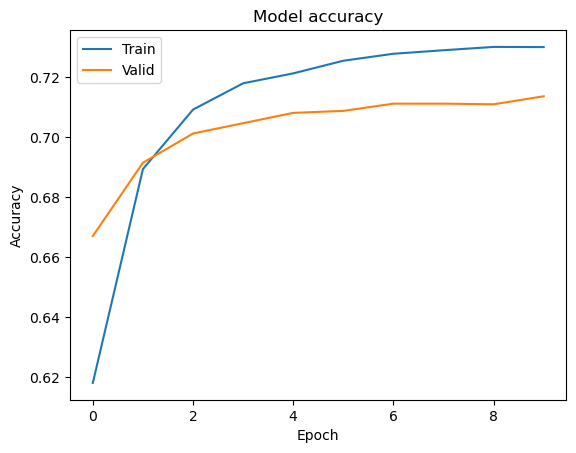

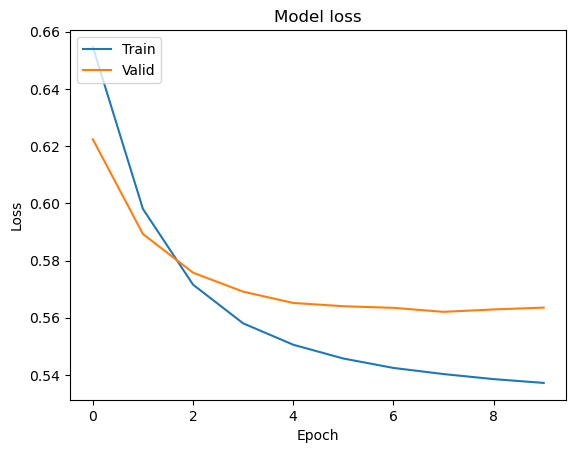

In [78]:
plot_history(history)

> **Answer here**:

So here we can see a quick conversion between the validation and training sets. And then the model starts overfitting and the train loss keeps decreasing but the validation loss is the same.


## Check output

On this last section, what we propose is to select a user and qualitatively check the prediction results to see what our system would recommend for a given user. You can also try with many different users if you want.

What we will do is to select the validation results for a given users (those which the model has not seen) and then compute the predictions for each film on this user to compare whether they make sense with the original ratings the user have given (ground-truth).

In [96]:
######################
# a) Select user_id and select all his/her validation results
#####################
user = val_df.user_id.values[0]

In [97]:
user_df = val_df[val_df.user_id == user]

In [98]:
print(user_df.index)
print(feature_num) # feature_num = len(config.category_col + config.num_col)

Int64Index([    0,   634,   705,   830,  1250,  1479,  1572,  1902,  3074,
             3139,  3476,  3720,  4060,  4297,  4306,  4833,  5211,  5327,
             5478,  5944,  6258,  8097,  8951,  8995,  9510,  9693, 11411,
            12441, 12690, 14304, 14482, 14544, 14553, 14592, 14648, 14949,
            15214, 15275, 15706, 15957, 16198, 16221, 16616, 16671, 17348,
            17501, 18149, 18249, 18791, 18821, 18862, 18961, 19128],
           dtype='int64')
24


In [99]:
user_inputs = [pp.transform(val_df)[user_df.index, i] for i in range(feature_num)]

In [101]:
######################
# b) Predict the results for 'user_inputs' variable and sort their predictions in descending order.
#####################

user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)# ... sort in descending order

2/2 [==============================] - 0s 3ms/step


In [102]:
# Finally, here we can observe the rating 
user_df[['title','rating','pred']].head(50)

,title,rating,pred
18862,"Shawshank Redemption, The (1994)",5,0.979938
14304,One Flew Over the Cuckoo's Nest (1975),2,0.962100
17348,"Empire Strikes Back, The (1980)",5,0.947760
18821,Monty Python and the Holy Grail (1974),5,0.935176
8097,Glory (1989),4,0.902034
9693,"Blues Brothers, The (1980)",5,0.894408
8995,Jerry Maguire (1996),5,0.863333
1479,Miracle on 34th Street (1994),3,0.853990
18249,What's Love Got to Do with It (1993),4,0.840617
3074,Pinocchio (1940),3,0.835786
